## Статистика, DS-поток
## Практическое задание 12


**Правила:**

* Дедлайн **30 ноября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 1 балл;
* Задача 2 &mdash; 14 баллов;
* Задача 3 &mdash; 8 баллов;
* Задача 4 &mdash; 8 баллов.

**Важность задач:**

* *высокая:* задачи 2, 3;
* *средняя:* задача 1, 4.

In [1]:
from sklearn.base import BaseEstimator

import scipy.stats as sps
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')
sns.set_style("whitegrid")


from collections import Counter
from sklearn.metrics import accuracy_score

# обратите внимание, что Scikit-Learn импортируется как sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as LinearRegression
from sklearn import metrics

from sklearn.linear_model import Ridge, Lasso, ElasticNet

__________________
## Задача 1.

Визуализируйте множество, которое ограничивает коэффициенты в Elastic-регрессии.

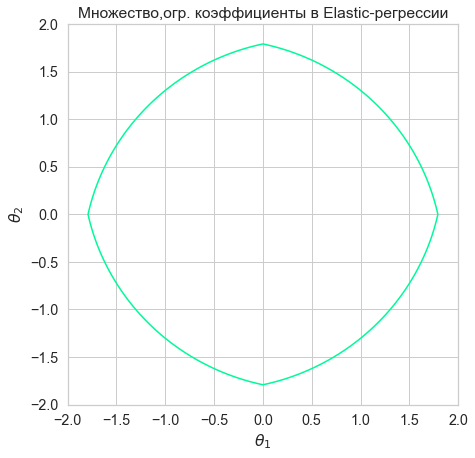

In [2]:
grid_1d = np.linspace(-2, 2, 10**3)
x, y = np.meshgrid(grid_1d, grid_1d)


l2 = x ** 2 + y ** 2
l1 = np.abs(x) + np.abs(y)
elastic = l1 + l2

plt.figure(figsize=(7, 7))

plt.contour(x, y, elastic, levels=[5], colors='#00FA9A')
plt.title('Множество,огр. коэффициенты в Elastic-регрессии')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.show()

Теперь давайте нарисуем на одном графике Ridge, Lasso,Elastic и сравним их

In [3]:
import ipywidgets as widgets
from ipywidgets import interactive
grid_1d = np.linspace(-1.1, 1.1, 10**3)
x, y = np.meshgrid(grid_1d, grid_1d)


l2 = x ** 2 + y ** 2
l1 = np.abs(x) + np.abs(y)
def elastic_func(l1_ratio=0.5):
    elastic=l1_ratio*l1+(1-l1_ratio)*l2
    ridge=l2
    lasso=l1
    plt.figure(figsize=(7, 7))

    Elastic=plt.contour(x, y, elastic, levels=[1],colors='#00FA9A')
    Ridge=plt.contour(x, y, ridge, levels=[1],colors='#BDB76B')
    Lasso=plt.contour(x, y, lasso, levels=[1],colors='#191970')
    plt.title('Множество,огр. коэффициенты в регрессиях')
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')

    Elastic.collections[0].set_label('Elastic')
    Ridge.collections[0].set_label('Ridge')
    Lasso.collections[0].set_label('Lasso')
    plt.legend()
    plt.show()

In [4]:
ip=interactive_plot = interactive(elastic_func, l1_ratio=widgets.FloatSlider(min=0.0001, max=1.01, step=0.01, value=0.5))
# отображаем слайдер
display(widgets.HBox(ip.children[:1]))

# отображаем вывод функции
display(ip.children[-1])
ip.update() # чтобы функция запустилась до первого изменения слайдеров

Output()

## Задача 2.

Вам предлагается изучить и сравнить свойства линейных регрессионных моделей: обычной и с регуляризациями &mdash; Lasso, Ridge, Elastic Net.  

При выполнении задания воспользуйтесь готовыми реализациями методов в sklearn.

Скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, в которых используйте следующие столбцы:
* `City` &mdash; город, данные для которого приводятся.
* `Cost of Living Index` &mdash; является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` &mdash; это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` &mdash; это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` &mdash; сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` &mdash; показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` &mdash; это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

In [5]:
data = pd.read_csv('cost-of-living-2018.txt', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]
data

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
0,145.43,110.87,128.76,158.75,112.26,143.47
1,141.25,66.14,105.03,135.76,142.70,149.86
2,134.83,71.70,104.38,129.74,130.96,138.98
3,130.68,49.68,91.61,127.22,139.01,127.54
4,128.03,43.57,87.30,119.48,112.71,132.70
...,...,...,...,...,...,...
535,24.65,6.31,15.80,13.94,77.70,26.93
536,24.61,5.35,15.32,15.21,53.23,25.23
537,23.78,4.34,14.40,17.66,23.75,23.19
538,23.44,6.25,15.15,14.14,111.99,24.02


**1.** Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров. Разделите данные на признаки $X$ и таргет $y$.

In [51]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

Разбейте данные на обучающую и тестирующие выборки в соотношении 7:3 с помощью `train_test_split`</a> из sklearn. Далее везде вплоть до сравнения моделей используйте обучающую выборку.

In [52]:
X_train, X_test,y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=17)

Методы с регуляризацией требуют страндартизации признаков. Поясните, почему это необходимо.

**Ответ:** Один из самых легких примеров для понимания-если у нас у признаков разные единицы, например: масса машины и количество лошадиных сил, но тогда мы будем скалдывать в функционале разные единицы (несколько тонн и число, которое обычно от 100 до 500), ни при какую точность модели тогда вообще не будет речь.

Примените стандартизацию к обучающей и тестовой выборкам, используя класс <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler">`StandardScaler`</a>, **обученный на обучающей выборке**.

In [53]:
from sklearn.preprocessing import StandardScaler
trans = StandardScaler()
X_train_tr = trans.fit_transform(X_train)
#затем нам надо стандартизировать данные в test на основе trans.fit(train)
X_test_tr = trans.transform(X_test)

**2.** Исследуйте зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессий. Для Elastic также исследуйте зависимость от параметра `l1_ratio`. Нарисуйте графики, используя код с семинара. Предложите диапазоны значений, где стоило бы искать оптимальные параметры регуляризации.

In [2]:
import warnings
warnings.filterwarnings("ignore")

def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(14, 6)):
    """
    Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации.
    
    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм 
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм 
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

### Ridge-регрессия

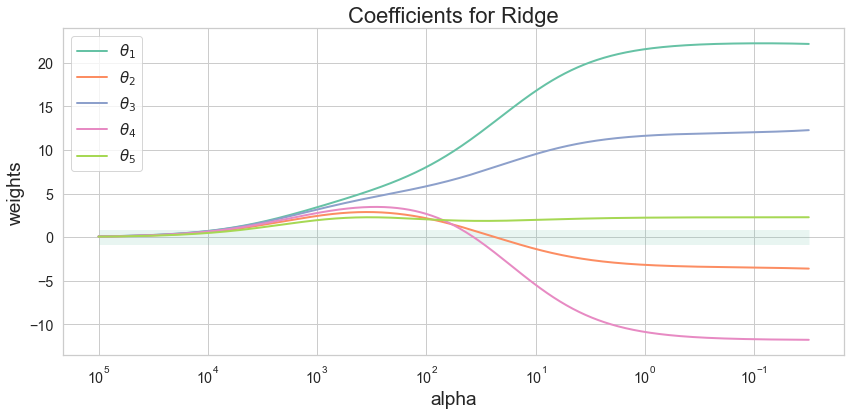

In [55]:
draw_track(Ridge(fit_intercept=True), X_train_tr, y_train, -1.5, 5, 10**3, title='Coefficients for Ridge')

### Lasso-регрессия

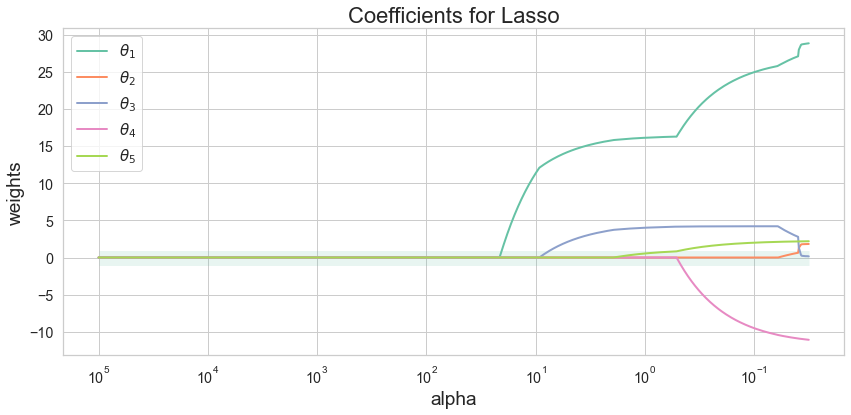

In [56]:
draw_track(Lasso(fit_intercept=True), X_train_tr, y_train, -1.5, 5, 10**3, title='Coefficients for Lasso')

### Elastic-регрессия

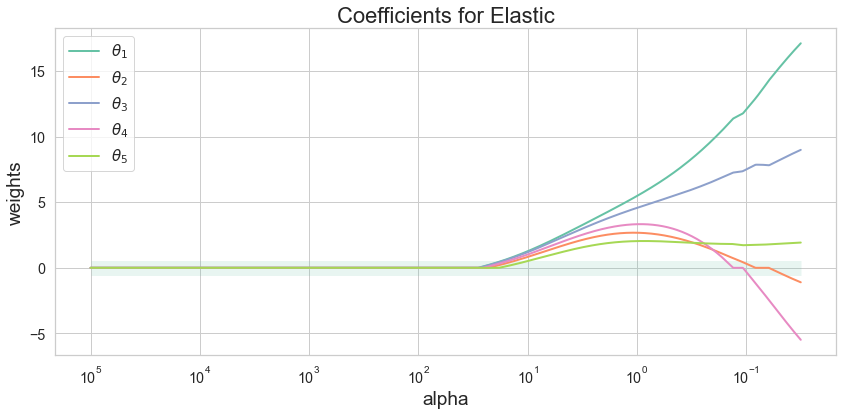

In [57]:
draw_track(ElasticNet(fit_intercept=True), X_train_tr, y_train, -1.5, 5, 10**3, title='Coefficients for Elastic')

*Мини-вывод* по графикам выше. 

В ридж мне кажется довольно хороший $\alpha\in[10^{0},10^1]$. Он еще не маленький(тогда будет просто обнулять теты), но уже и не такой большой, как справа. Кажется, что золотая середина.

В лассо, как и ожидалось значения коэффициентов  в какой-то момент оч сильно падают до 0, поэтому он и хорош для отбора определенных признакаков начиная с некоторого значения коэффициента регуляризации. Вот тут я предложу $\alpha\in[0,10^{-1}]$. Тут большая часть коэфф. еще не обнулилась, но при этом уже произошел отбор некоторых признаков.

Теперь поговорим насчет Elastic.Мы знаем из теории, что это смесь риджа и лассо. Тут коэффициенты тоже обнуляются довольно резко после какого-то граничного значения, но все же не так резко, как в лассо, но и побыстрей, чем в ридже. 
Вот тут опять же я предложу $\alpha\in[10^{0},10^{-1}]$

Расчитайте индекс обусловленности для МНК-решения. Можно ли сделать вывод о мультиколлинеарности данных?  
Нарисуйте график зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии. 

Для этого надо рассмотреть значения матрицы $(X^T X+ \lambda\mathbf{1}_d)^{-1}$ и посчитать для нее индекс обусловленности $\sqrt{\left.\lambda_{max}\right/\lambda_{min}}$, где $\lambda_{max}, \lambda_{min}$ — максимальный и минимальный собственные значения матрицы $X^T X+ \lambda\mathbf{1}_d$.

In [58]:
#индекс обусловленности
def add_column_one(matrix):#константный признак
    ones = np.ones((matrix.shape[0], 1))
    return(np.concatenate((ones, matrix), axis=1))
matrix_X=add_column_one(X_train_tr)
d=matrix_X.shape[1]

CI стало в первый раз меньше 30 при параметре регуляризации равным 1.785


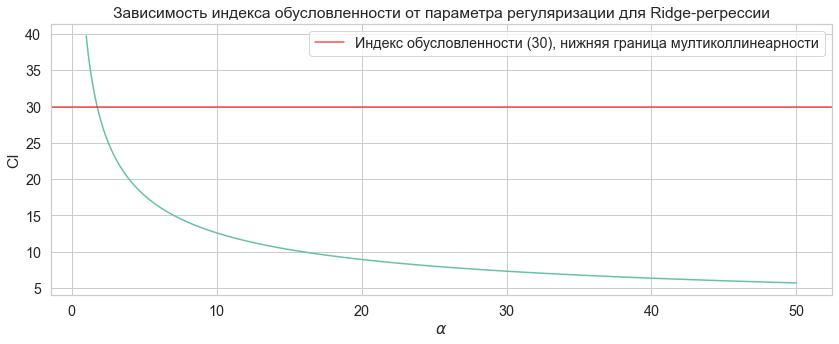

In [59]:
alphas=np.linspace(1,50,10**3)
res_CI=[]
first=True
for alpha in alphas:
    CI=(np.linalg.eigh(matrix_X.T@matrix_X+alpha*np.eye(d))[0].max()/
        np.linalg.eigh(matrix_X.T@matrix_X+alpha*np.eye(d))[0].min())**0.5
    res_CI.append(CI)
    if (CI<30 and first):
        first=False
        print(r'CI стало в первый раз меньше 30 при параметре регуляризации равным {}'.format('%.3f'%alpha))
    
plt.figure(figsize=(14, 5))
plt.plot(alphas, res_CI)
plt.axhline(y=30, color='red', alpha=0.7, label='Индекс обусловленности (30), нижняя граница мултиколлинеарности')
plt.title(r'Зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'CI')
plt.legend()
plt.show()

**3.** С помощью кросс-валидации определите наилучшие параметры для Ridge, Lasso, Elastic моделей. В качестве метрики качества используйте среднеквадратичную ошибку (MSE).

*Замечание.* Не забудьте, что при стандартизации была использована вся обучающая выборка, а внутри кросс-валидации на каждой итерации рассматривается своя валидационная выборка, которая не должна стандартизироваться по данным, посчитанным частично на ней самой. Вам может помочь [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

def res_cross_val_score(model):#ручной GridSearchCV написал для себя
    scalar = StandardScaler()

    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    scores = cross_val_score(
        estimator=pipeline, # модель, качество которой хотим оценить
        X=X_train, # данные для обучения (не содержат целевую переменную)
        y=y_train, # значения целевой переменной
        cv=5, # количество фолдов
        scoring='neg_mean_squared_error', # метрика качества
        n_jobs=-1 # количество ядер для вычислений, -1 - использование всех ядер
    )
    return np.mean(scores)

In [92]:
kf = KFold(
    n_splits=5,  # количество фолдов 
    shuffle=False  # перемешиваем ли данные перед разбиением
)
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
def Search_with_GridSearchCV(model, grid):
    #сам GridSearchCV
    scalar = StandardScaler()

    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    gs = GridSearchCV(
            # модель для обучения, в нашем случае Ridge
            estimator=pipeline,
            # сетка значений гиперпараметров
            param_grid=grid,
            # метрика качества, берем MSE
            scoring='neg_mean_squared_error',
            # GridSearch отлично параллелится, указываем количество параллельных джоб
            # -1 означает использование всех ядер
            n_jobs=-1,
            # стратегия кросс-валидации
            cv=kf,
            # сообщения с логами обучения: больше значение - больше сообщений
            verbose=0,
            # значение, присваиваемое scorer в случае ошибки при обучении
            error_score='raise'
    )
    gs.fit(X_train, y_train)
    results = gs.cv_results_
    res_data=pd.DataFrame(results)
    return (gs.best_params_,res_data.mean_test_score, res_data)


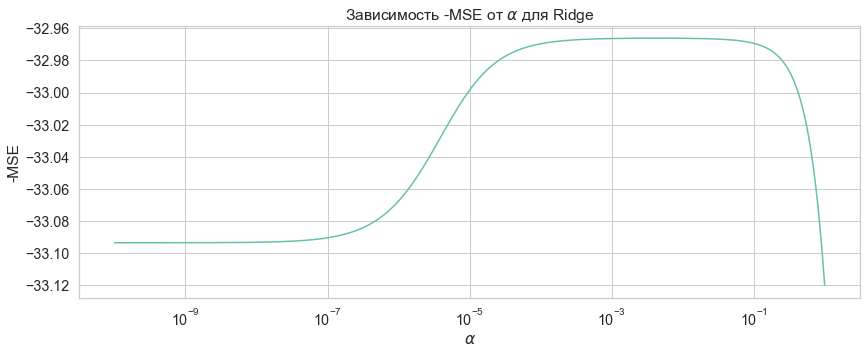

Наилучшим параметром является 0.004


In [93]:
#ridge
grid=np.logspace(-10,0,10**3)
res_ridge=Search_with_GridSearchCV(Ridge(),{'estimator__alpha' : grid})

plt.figure(figsize=(14, 5))
plt.plot(grid, res_ridge[1])
plt.title(r'Зависимость -MSE от $\alpha$ для Ridge')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'-MSE')
plt.xscale('log')
plt.show()
print('Наилучшим параметром является','%.3f' %res_ridge[0]['estimator__alpha'])

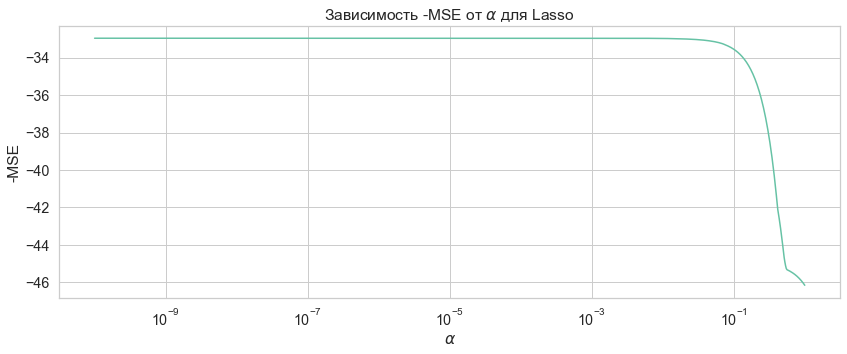

Наилучшим параметром является 0.001


In [94]:
#Lasso
grid=np.logspace(-10,0,10**3)
res_lasso=Search_with_GridSearchCV(Lasso(),{'estimator__alpha' : grid})

plt.figure(figsize=(14, 5))
plt.plot(grid, res_lasso[1])
plt.title(r'Зависимость -MSE от $\alpha$ для Lasso')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'-MSE')
plt.xscale('log')
plt.show()
print('Наилучшим параметром является','%.3f' %res_lasso[0]['estimator__alpha'])

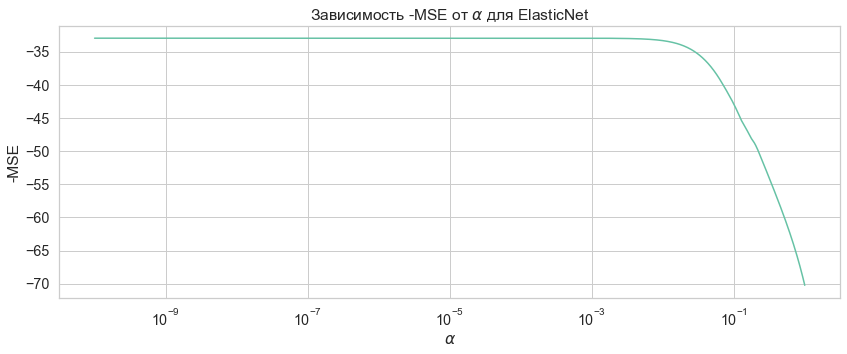

Наилучшим параметром является 0.0001


In [95]:
#ElasticNet
grid=np.logspace(-10,0,10**3)
res_elastic=Search_with_GridSearchCV(ElasticNet(),{'estimator__alpha' : grid})

plt.figure(figsize=(14, 5))
plt.plot(grid, res_elastic[1])
plt.title(r'Зависимость -MSE от $\alpha$ для ElasticNet')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'-MSE')
plt.xscale('log')
plt.show()
print('Наилучшим параметром является','%.4f' %res_elastic[0]['estimator__alpha'])

Но в elastic можно настраивать не только 1 параметр ($\alpha$), как мы сделали выше, а сразу 2 параметра. Давайте вычислим лучшую комбинацию параметров

In [96]:
grid=np.logspace(-10,0,10**2)
grid_l_1=np.linspace(0, 1,10**1)
res_elastic=Search_with_GridSearchCV(ElasticNet(),{'estimator__alpha' : grid,'estimator__l1_ratio' : grid_l_1})

In [97]:
print('Наилучшим параметром является','%.4f' %res_elastic[0]['estimator__alpha'],'%.4f' %res_elastic[0]['estimator__l1_ratio'])

Наилучшим параметром является 0.0024 0.8889


На тестовой части данных сравните качество моделей с оптимальными параметрами. Какая модель дала лучший результат?

In [98]:
model=Ridge(alpha=res_ridge[0]['estimator__alpha'], fit_intercept=True)
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)
MSE=metrics.mean_squared_error(y_test, y_pred)
print('MSE с оптимальным параметров для Ridge равен {}'.format('%.4f' %MSE))

model=Lasso(alpha=res_lasso[0]['estimator__alpha'], fit_intercept=True)
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)
MSE=metrics.mean_squared_error(y_test, y_pred)
print('MSE с оптимальным параметров для Lasso равен {}'.format('%.5f' %MSE))

model=ElasticNet(alpha=res_elastic[0]['estimator__alpha'],l1_ratio=res_elastic[0]['estimator__l1_ratio'], fit_intercept=True)
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)
MSE=metrics.mean_squared_error(y_test, y_pred)
print('MSE с оптимальным параметров для Elastic равен {}'.format('%.5f' %MSE))

MSE с оптимальным параметров для Ridge равен 36.3314
MSE с оптимальным параметров для Lasso равен 36.33713
MSE с оптимальным параметров для Elastic равен 36.38932


Важно, что в GridSearch я использую ss, а не kf. Результаты по итогу немного отличаются. Если я использую ss(как сейчас в коде), то самое маленькое MSE дает нам Lasso, затем уже Elastic и Ridge. Но если использовать kf, то получаем вот такой порядок Ridge, Elastic, Lasso. То есть в каждый раз Elastic у нас по серединке, что довольно логично, так как это что-то среднее между Lasso and Ridge по опр

**4.** Исследуйте остатки модели Ridge-регрессии. Можно ли говорить о гомоскедастичности. Если нет, попытайтесь несложными преобразованиями признаков и отклика визуально прийти к гомоскедастичности.

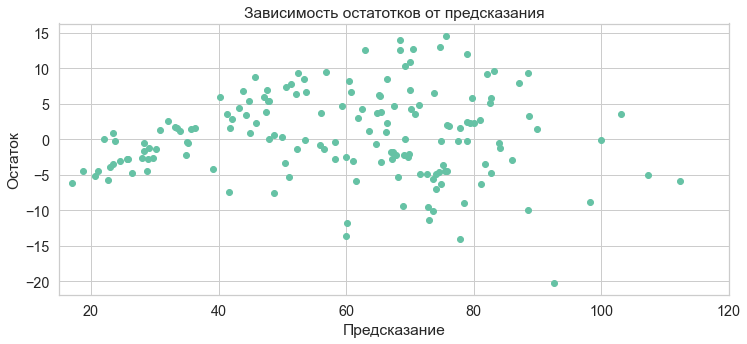

In [108]:
model=Ridge(alpha=res_ridge[0]['estimator__alpha'])
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

plt.figure(figsize=(12, 5))
y_res=y_pred - y_test
plt.scatter(y_pred,  y_res)
plt.xlabel('Предсказание')
plt.ylabel('Остаток')
plt.title('Зависимость остатотков от предсказания')
plt.xlim([15, 120]);

Смотря на график, не могу говорить о гомоскедастичности. Давайте посмотрим на графики зависимости по каждому признаку.

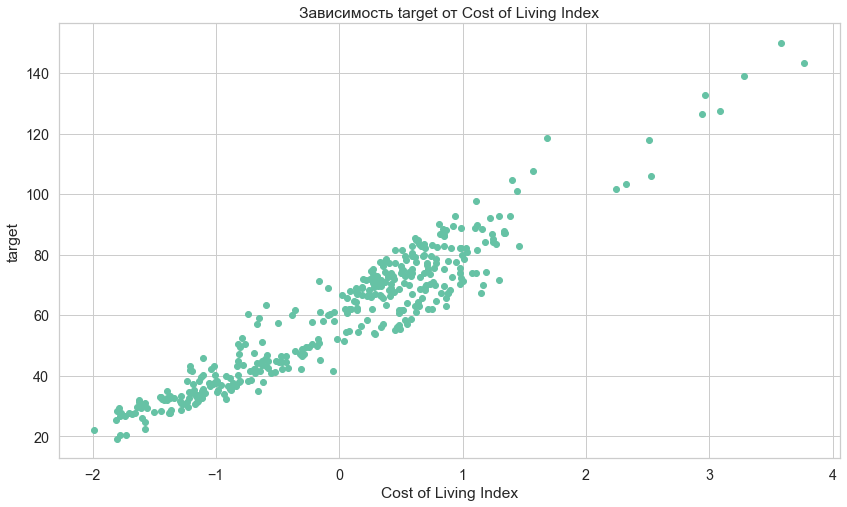

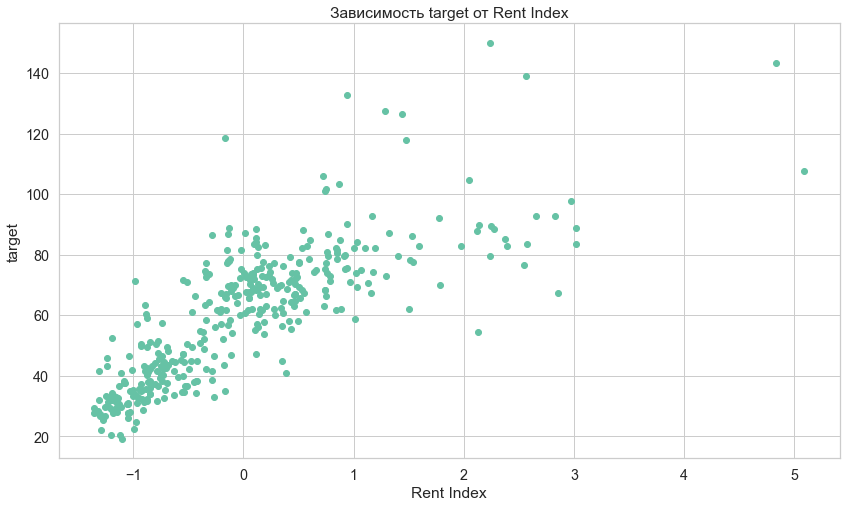

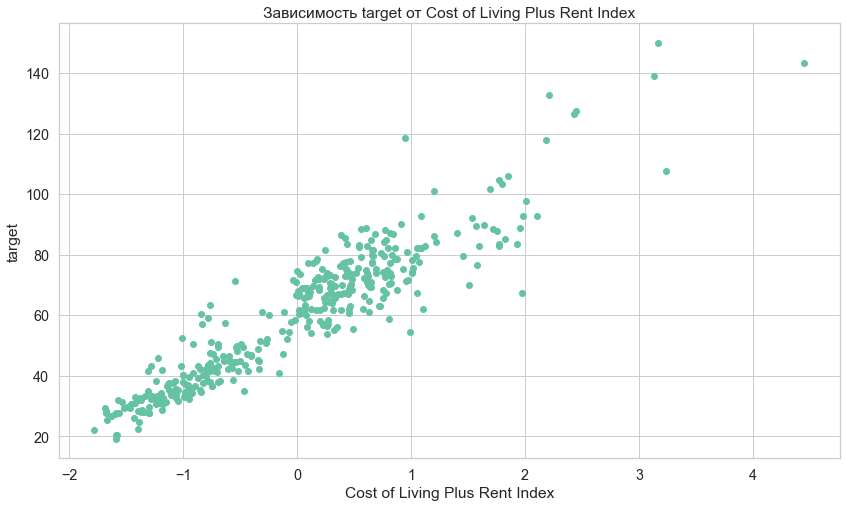

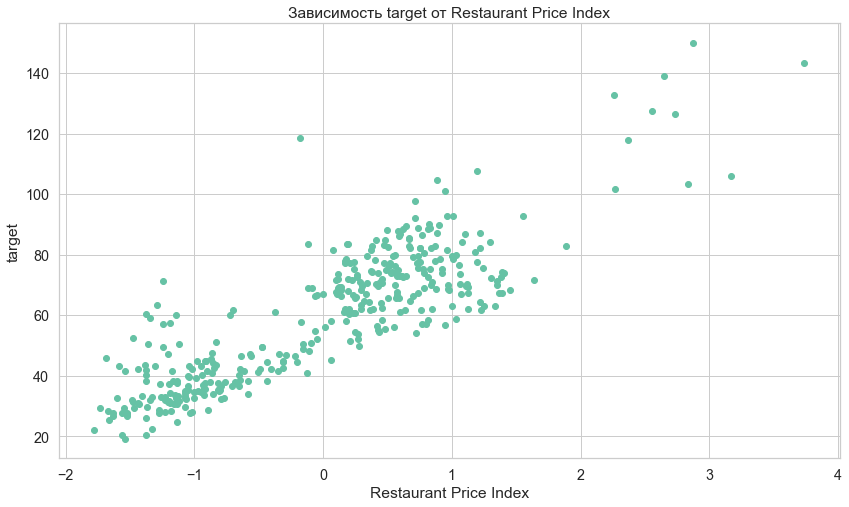

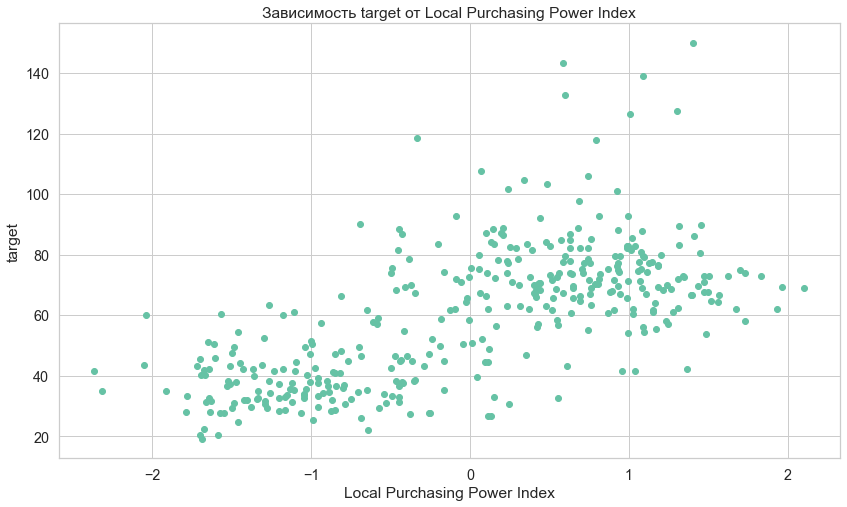

In [112]:
real_features=['Cost of Living Index','Rent Index','Cost of Living Plus Rent Index','Restaurant Price Index',
               'Local Purchasing Power Index']

for i,real_feature_now_i in enumerate(real_features):
    plt.figure(figsize=(14,8))
    plt.scatter(X_train_tr[:,i],y_train)
    plt.xlabel(real_feature_now_i)
    plt.ylabel('target')
    plt.title('Зависимость target от {}'.format(real_feature_now_i))

Теперь точно можно точно говорить, что у нас нет гомоскедастичности, особенно это хорошо видно на последнем графике и на 2 графике. На семинаре разбирался вариант с навешиванием log. Давайте сделаем это.

In [127]:
data.min()
#нет отрц. чисел, прекрасно

Cost of Living Index              20.86
Rent Index                         3.82
Cost of Living Plus Rent Index    13.26
Restaurant Price Index            12.06
Local Purchasing Power Index       1.88
Groceries Index                   19.26
dtype: float64

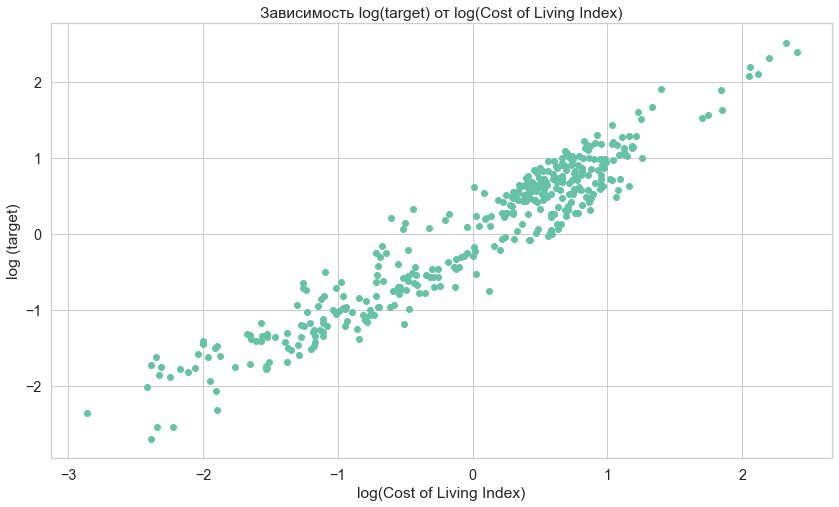

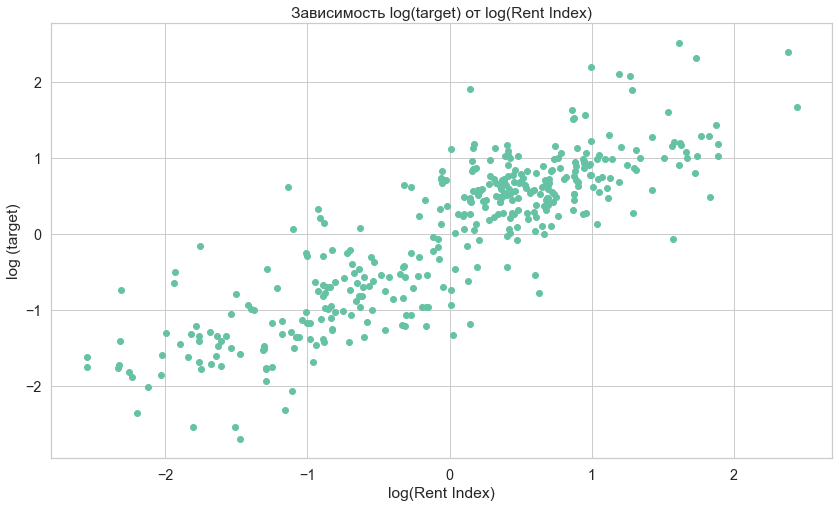

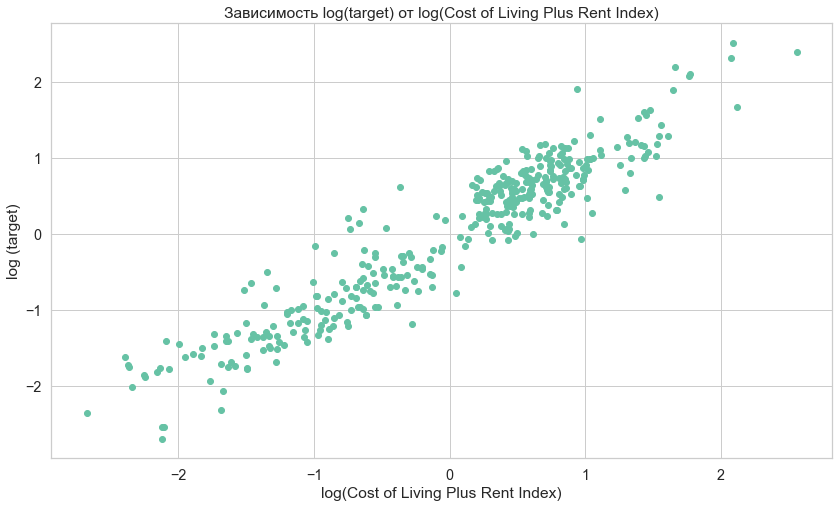

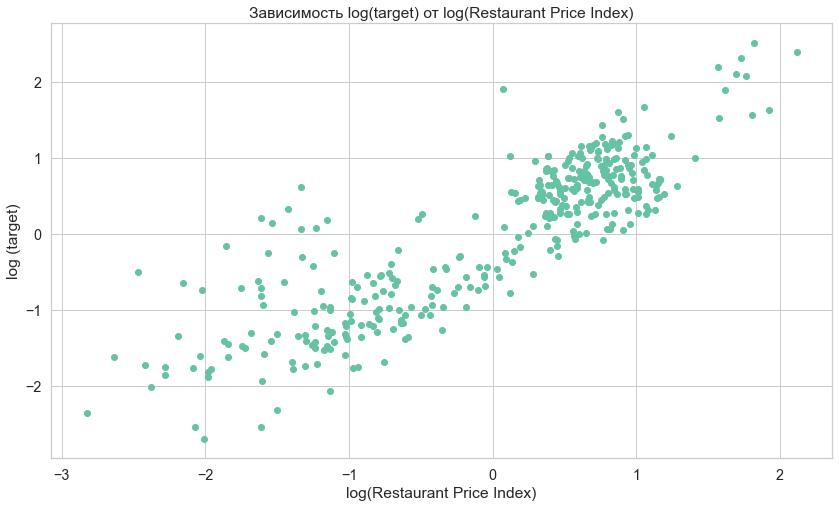

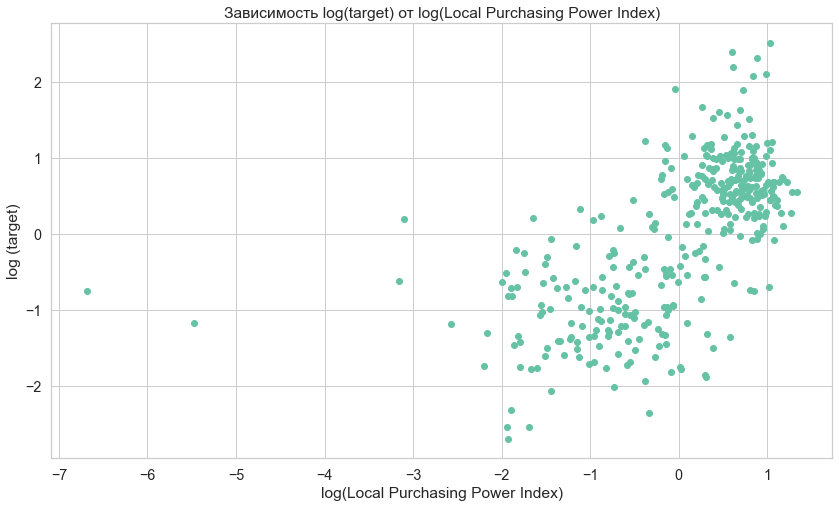

In [133]:
#давайте попробуем поиграться с log    
data_log=np.log(data)
data_log=data_log.dropna()

X_train_log, X_test_log,y_train_log, y_test_log=train_test_split(data_log.iloc[:,:-1],data_log.iloc[:,-1], 
                                                                 test_size=0.3, random_state=17)
n = X_train_log.shape[0]  # количество объектов 
d = X_test_log.shape[1]  # количество признаков

X_train_log = (X_train_log - X_train_log.mean(axis=0)) / X_train_log.std(axis=0)
y_train_log = (y_train_log - y_train_log.mean()) / y_train_log.std()


for i,real_feature_now_i in enumerate(real_features):
    plt.figure(figsize=(11,8))
    plt.scatter(X_train_log.iloc[:,i],y_train_log)
    plt.xlabel('log('+real_feature_now_i+')')
    plt.ylabel('log (target)')
    plt.title('Зависимость log(target) от log({})'.format(real_feature_now_i))



Как видно все стало намного лучше, теперь уже можно говорить по графикам про гомоскедастичность. Теперь давайте снова построим график остатков от предсказаний

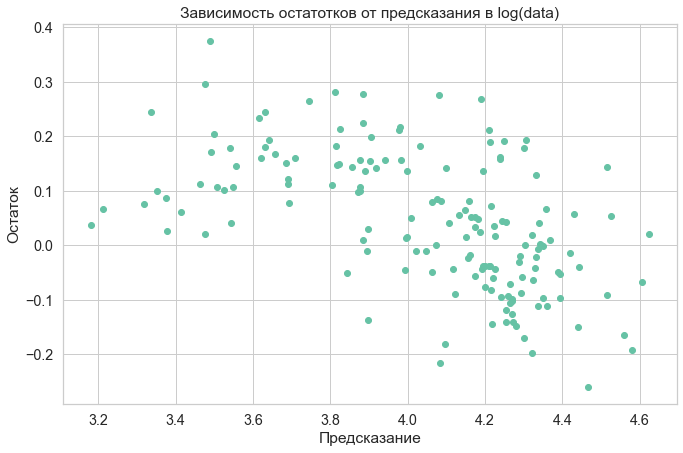

In [138]:
scalar = StandardScaler()
grid={'estimator__alpha' : np.logspace(-10,0,10**3)}
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
gs = GridSearchCV(
        # модель для обучения, в нашем случае Ridge
        estimator=pipeline,
        # сетка значений гиперпараметров
        param_grid=grid,
        # метрика качества, берем MSE
        scoring='neg_mean_squared_error',
        # GridSearch отлично параллелится, указываем количество параллельных джоб
        # -1 означает использование всех ядер
        n_jobs=-1,
        # стратегия кросс-валидации
        cv=ss,
        # сообщения с логами обучения: больше значение - больше сообщений
        verbose=0,
        # значение, присваиваемое scorer в случае ошибки при обучении
        error_score='raise'
)
gs.fit(X_train_log, y_train_log)

#подобрали оптимальный параметр
y_pred = gs.predict(X_test_log)

plt.figure(figsize=(11, 7))
y_res=y_pred - y_test_log
plt.scatter(y_pred,  y_res)
plt.xlabel('Предсказание')
plt.ylabel('Остаток')
plt.title('Зависимость остатотков от предсказания в log(data)');

**Мини-вывод** Как мы видим, хоть на обычных графиках log(target) от log(feature) гомоскедастичность, то с остатками у нас все же не такая радужная ситуация, но прит этом это все равно лучше, чем было. Так что мы проверили, что с помощью log можно визуально изменить гетеростатичные данные на гомоскедастичные.

С помощью модели Ridge-регрессии постройте предсказательный интревал для наблюдаемого отклика уровня доверия $0.95$. Какой смысл имеет этот интервал? В чем его отличие от доверительного интервала? Посчитате долю точек выходящих за предсказательный интревал.

*Давайте* воспользуемся материалом с семинара

Для оценки параметра 1/$\beta$ используем оценку $\frac{\lVert Y - X \theta\rVert^2_2}{n - d}$

In [144]:
'''b = (n - d) / np.sum((y_pred - y) ** 2) 
a = reg_coef * b
sigma = 1 / (b * X.T @ X + a)
'''

'b = (n - d) / np.sum((y_pred - y) ** 2) \na = reg_coef * b\nsigma = 1 / (b * X.T @ X + a)\n'

Построим предиктивные интервалы для отклика. Для этого вспомним, что в линейной гауссовской модели $\varepsilon$ ~ $\mathcal{N}(0, \beta^{-1} I_n)$. 

Пусть $x_0$ &mdash; новый объект, а $y_0 = x_0^T\theta + \varepsilon_0$ &mdash; наблюдаемый отклик на $x_0$. 

Тогда 

$$
Y_0 | Y \sim \mathcal{N} \left( \beta x_0^T  \Sigma  X^T  Y, x_0^T  \Sigma  x_0 + \beta^{-1} \right).
$$
Квантили данного распределения задают границы предиктивного интервала.

In [225]:
X = X_train_log.to_numpy()
y = y_train_log.to_numpy()

n = X.shape[0]  # количество объектов 
d = X.shape[1]  # количество признаков

X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

reg_coef = gs.best_params_['estimator__alpha']
model = Ridge(alpha=reg_coef)
model.fit(X, y)
y_pred = model.predict(X)

b = (n - d) / np.sum((y_pred - y) ** 2) 
a = reg_coef * b
sigma = np.linalg.inv((b * X.T @ X + a*np.eye(d)))#изменили функцию, так  как у нас d параметров



In [231]:
from scipy.stats import norm
left = []
right = []
estimations = []

for i,x0 in enumerate(X):
    x0 = x0.reshape(-1, 1)
    y0 = model.predict(x0.T)
    estimations.append(y0)
    
    distr = norm(
        (b * x0.T @ sigma @ X.T @ y), (np.sqrt(x0.T @ sigma @ x0 + 1 / b))
    )
    left.append(distr.ppf(0.975).ravel())
    right.append(distr.ppf(0.025).ravel())
left=np.array(left)
right=np.array(right)

In [232]:
left.shape#ура, получили нужного размера left

(378, 1)

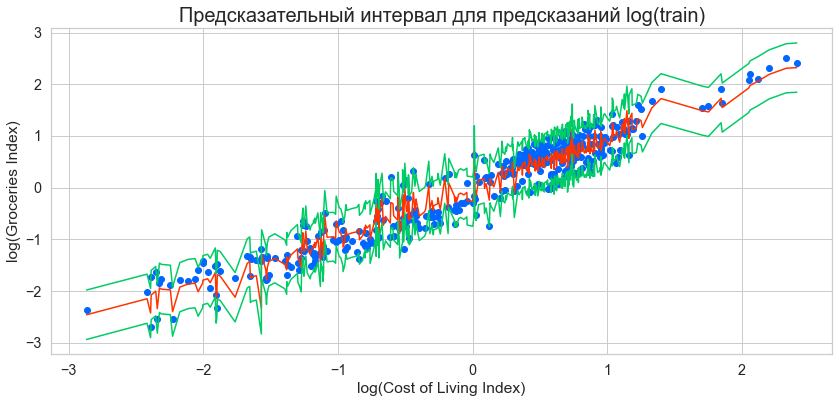

Доля точек выходящих за предсказательный интревал равна 0.037


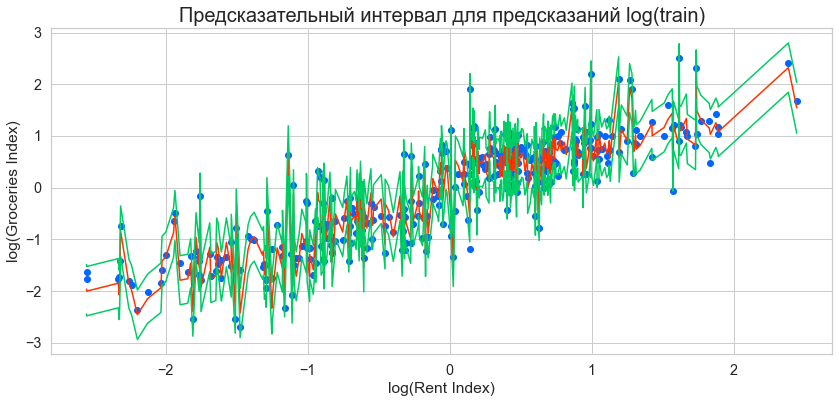

Доля точек выходящих за предсказательный интревал равна 0.037


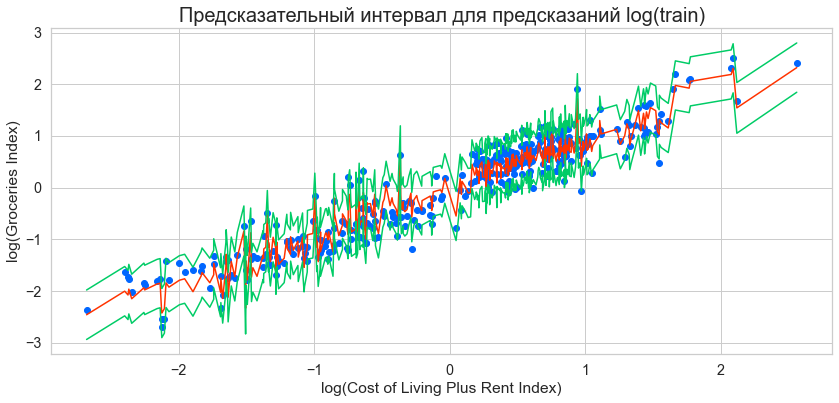

Доля точек выходящих за предсказательный интревал равна 0.037


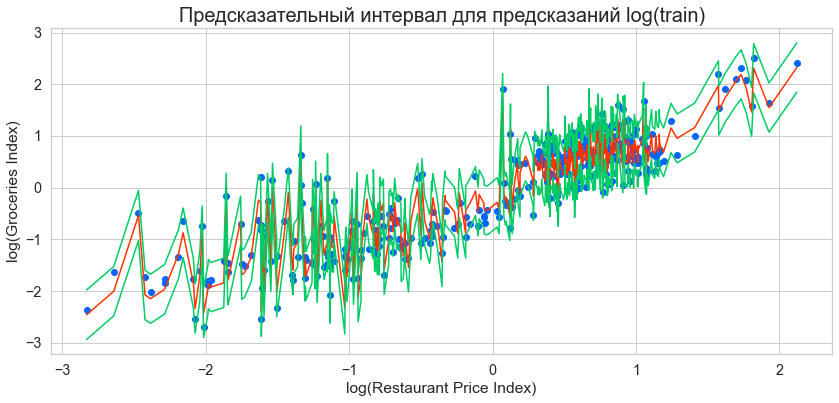

Доля точек выходящих за предсказательный интревал равна 0.037


In [283]:
for i,feature in enumerate(real_features[:-1]):
    pairs=np.c_[X[:,i],left,right,estimations,y]
    pairs=np.array(sorted(pairs, key=lambda x: x[0]))

    x=pairs[:,0]
    l=pairs[:,1]
    r=pairs[:,2]
    est=pairs[:,3]
    y_point=pairs[:,4]
    
    
    plt.figure(figsize=(14,6))

    plt.scatter(X[:,i], y, c='#0066FF')
    plt.plot(x, est, color='#FF3300',label='Предсказание')
    plt.plot(x, l, color='#00CC66',label='Левая граница предсказ. интервала')
    plt.plot(x, r, color='#00CC66',label='Правая граница предсказ. интервала')

    plt.title('Предсказательный интервал для предсказаний log(train)', fontsize=20)
    plt.xlabel('log('+feature+')')
    plt.ylabel('log(Groceries Index)')
    plt.show()
    count_point=np.sum((y_point>l) | (y_point<r))
    print('Доля точек выходящих за предсказательный интревал равна', '%.3f' %(count_point/len(y_point)))

**5.** Сделайте общий вывод по задаче.

Предсказательный интервал-это грубо говоря, доверительный интервал, для предсказания. То есть она рисует границы области, куда попадет $\alpa$ доля точек, предсказанных нашей моделью. Отличие от обычного дов. интервала в том, что при подсчете дов. интервала мы не учитываем шум (дисперсию в нашей модели), а вот предсказательный интервал уже учитываем шум, поэтому он всегда шире, чем доверительный интервал.
Графики получлись так себе, так как на семинаре мы строили модель только от одного признака, а тут сразу 5 признаков, поэтому нам пришлось в некоторых строчках поменять код. То есть тут хорошо видно, что нет красивых ровных границ, так как наш таргет зависит не только от одного признака(от которого мы строим наш график, а от всех признаков сразу). Но предсказательный интервал построился правильно, так как доля точек, которые не попали в него равна меньше 5%, что и просили от нас

## Задача 3.

В этой задаче вам предлагается расмотреть и сравнить две стратегии поиска оптимальных значений некоторого функционала: GridSearch и RandomSearch. В реальной жизни значение функционала &mdash; это значение целевой метрики качества, а оптимизация идет по гиперпараметрам некоторой модели машинного обучения. Коротко напомним, в чем же заключается каждая стратегия.

* GridSearch &mdash; полный перебор по сетке. Суть перебора по сетке заключается в следующем: вы задаете область значений гиперпараметров, которые хотите оптимизировать, обучаете все модели, которые возможно получить в рамках заданного пространства поиска гиперпараметров. Затем выбираете из данных моделей ту, которая дала наилучшее качество на кросс-валидации.
* RandomSearch &mdash; это стратегия, при которой рассматривается некоторая выборка из множества значений гиперпараметров. По умолчанию часто используется равномерное распределение. Лучшая модель выбирается так же на основе кросс-валидации.

Разберем сначала **одномерный случай**. Для этого рассмотрим следующую функцию.

In [15]:
def f(x):
    return 5.2 - 5/(1+(3*(x))**2) - np.cos(x)/5

Поcтройте график функции $f(x)$ на отрезке $[-20, 20]$. В чем его особенность?

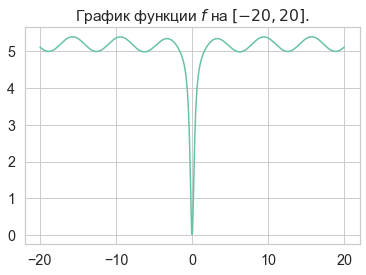

In [16]:
grid=np.linspace(-20,20,10**3)
plt.plot(grid, f(grid))
plt.title(r'График функции $f$ на $[-20,20].$')
plt.show()

In [17]:
f(0)

1.6653345369377348e-16

Подумайте, какие проблемы могут возникнуть при поиске минимума этой функции, если используется поиск по сетке?

**Ответ:**  Минимум достигается только в одной точке, а поиск по сетке будет проверять множество значений (что будет долго), хотя нам нужно только посчитать значение в одной точке и все. А еще, если точка 0 не попала в нашу сетку, то тогда мы будем находить какой-то локальный минимум, но не то, что нужно нам. Также хотел бы обратить внимание, что f(0)=0, но из-за машинной арифметики мы не получаем точно 0.

Рассмотрим **поиск по сетке** и проведем вычислительный эксперимент. Для этого будем генерировать случайное смещение из $U[-0.5, 0.5]$, а затем рассматривать смещенную на $x_0$ сетку размера $n$ на отрезке $[-10, 10]$, после чего поиском по сетке искать оптимальное значение $f$.

In [18]:
# рассматриваемые размеры сеток
grid_size = np.arange(2, 1000)
n_experiments = 100  # количество экспериментов

In [19]:
# массив для минимумов по сетке для текущего эксперимента
grid_min_f_trace = []
for experiment in tqdm(range(n_experiments)):
    # случайное смещение сетки на [-0.5, 0.5]
    x_0 = sps.uniform(loc=-0.5,scale=1).rvs(1)
    # массив для минимумов для текущего размера сетки
    grid_f_min = []
    # цикл по размеру сетки
    for n in grid_size:
        # сетка на [-10, 10] размера n
        grid = np.linspace(-10,10,n)
        grid=grid+x_0
        # найденный по сетке со смещением x_0 минимум функции f
        f_min = np.min(f(grid))
        # сохраним минимум для сетки размера n
        grid_f_min.append(f_min)
    # сохраним минимумы текущего эксперимента
    grid_min_f_trace.append(grid_f_min)

  0%|          | 0/100 [00:00<?, ?it/s]

Для нескольких экспериментов постройте графики значений минимума от количества точек в сетке. 
Для большей наглядности и информативности сразу **зафиксируйте диапазон значений по оси y**, а также отображайте графики в **логарифмическом масштабе**.

In [20]:
from plotly.offline import plot
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=grid_min_f_trace[0],
        name=r'$\text{эксперимент 0}$',
))
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=grid_min_f_trace[53],
        name=r'$\text{эксперимент 53}$',
))
fig.update_layout(
        title=r'$\text{графики значений минимума от количества точек в сетке равномерная сетка}$',
        xaxis_title=r'Количество точек в сетке',
        yaxis_title=r'Минимум',
        legend=dict(itemsizing='trace'),
        yaxis_range=[0, 1e-1],
        xaxis_type='log'
    )
plot(fig, filename='3.1d_grid.html', auto_open=False)
fig.show()

Теперь рассмотрим **случайный поиск**. Снова проведем вычислительный эксперимент. Обратите внимание, что случайные точки для эксперимента мы генерируем один раз.

In [21]:
# рассматриваемое количество случайных точек
random_size = np.arange(2, 1000)

In [27]:
# массив для минимумов для текущего эксперимента
random_min_f_trace = []

# цикл по экспериментам
for experiment in tqdm(range(n_experiments)):
    # случайное смещение на [-0.5, 0.5]
    x_0 = sps.uniform(loc=-0.5,scale=1).rvs(1)
    # массив для минимумов для текущего количества точек
    random_min_f = []
    # сгенерируем случайные на [-10, 10] точки сразу
    points = sps.uniform(loc=-10,scale=20).rvs(np.max(random_size))
    points=np.array(points)-x_0
    #цикл по количеству точек
    for n in random_size:
        # найденный по первым n случайным точкам со смещением x_0 минимум функции f
        grid=points[:n+1]
        f_min = np.min(f(grid))
        # сохранение результатов
        random_min_f.append(f_min)
        
    random_min_f_trace.append(random_min_f)

  0%|          | 0/100 [00:00<?, ?it/s]

Снова для нескольких экспериментов постройте графики значений минимума от количества точек при случайном поиске.

In [28]:
from plotly.offline import plot
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=random_min_f_trace[0],
        name=r'$\text{эксперимент 0}$',
))
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=random_min_f_trace[53],
        name=r'$\text{эксперимент 53}$',
))
fig.update_layout(
        title=r'$\text{графики значений минимума от количества точек в сетке случайная сетка}$',
        xaxis_title=r'Количество точек в сетке',
        yaxis_title=r'Минимум',
        legend=dict(itemsizing='trace'),
        xaxis_type='log'
    )
plot(fig, filename='3.1d_random.html', auto_open=False)
fig.show()

Сравним два метода. Для этого постройте график зависимости найденного минимума от количества точек (случайных или в сетке). Перед этим предварительно усредните результат по количеству экспериментов. Какие результаты у вас получились?

In [29]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=np.mean(grid_min_f_trace,axis=0),
        name=r'$\text{Равномерная сетка}$',
))
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=np.mean(random_min_f_trace,axis=0),
        name=r'$\text{Рандомная сетка}$',
))
fig.update_layout(
        title=r'$\text{графики значений минимума от количества точек в сетке случайная сетка}$',
        xaxis_title=r'Количество точек в сетке',
        yaxis_title=r'Минимум',
        legend=dict(itemsizing='trace'),
        xaxis_type='log'
    )
plot(fig, filename='3.1d_comp.html', auto_open=False)
fig.show()

*Мини-вывыд*, общий будет в конце таски. Тут хорошо видно, что в одномерном случае лучше использовать равномерную сетку со случайным смещением, это дает более точный результат, но в реальных задачах почти никогда нет только 1 параметра, поэтому давайте посмотрим, что будет, есди будет уже 2 параметра. Но видно, что у равномерной сетки скачки оч большие при маленьких $n$

Теперь расмотрим **двумерный случай**, для этого определим следующую функцию:

In [40]:
def f(x, y):
    return 5.4 - 5/(1+(3*x)**2) - np.cos(x)/5 - np.cos(y)/5

Постройте тепловую карту значений этой функции на $[-20, 20]^2$.

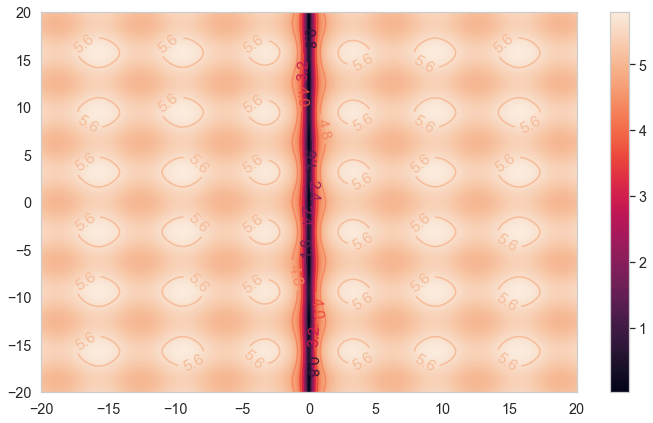

In [41]:
plt.figure(figsize=(12, 7))
plt.grid(False)
x = np.linspace(-20,20, 10**3)
y = np.linspace(-20,20, 10**3)
X, Y = np.meshgrid(x,y)
res=plt.pcolormesh(X,Y,f(X,Y))
plt.colorbar(res)

CS = plt.contour(X, Y, f(X,Y))
plt.clabel(CS);

Проведите эксперимент, аналогичный одномерному случаю. В случае поиска по сетке рассмотрите сетку размера $n$ на $[-10, 10]$ по каждой координате. Таким образом, общий размер сетки будет $n^2$. Для ускорения вычислений в случае случайного поиска будет достаточно рассмотреть только такое количество точек, которое соответствует рассмотренным размерам сетки (т.е. квадраты чисел).

Сравните результат с полученным ранее. Сделайте вывод.

In [43]:
# рассматриваемые размеры сеток
grid_size = np.arange(2, 1000)
n_experiments = 100  # количество экспериментов
# рассматриваемое количество случайных точек
random_size = np.arange(2, 1000)

In [44]:
# массив для минимумов по сетке для текущего эксперимента
grid_min_f_trace_2d = []
for experiment in tqdm(range(n_experiments)):
    # случайное смещение сетки на [-0.5, 0.5]
    x_0 = sps.uniform(loc=-0.5,scale=1).rvs(1)
    y_0 = sps.uniform(loc=-0.5,scale=1).rvs(1)
    # массив для минимумов для текущего размера сетки
    grid_f_min = []
    # цикл по размеру сетки
    for n in (grid_size):
        # сетка на [-10, 10] размера n
        grid_x = np.linspace(-10,10,n)+x_0
        grid_y = np.linspace(-10,10,n)+y_0
        
        X_n, Y_n = np.meshgrid(grid_x,grid_y)
        res=f(X_n,Y_n)
        # найденный по сетке со смещением x_0 минимум функции f
        f_min = np.min(res)
        # сохраним минимум для сетки размера n
        grid_f_min.append(f_min)
    # сохраним минимумы текущего эксперимента
    grid_min_f_trace_2d.append(grid_f_min)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=grid_min_f_trace_2d[0],
        name=r'$\text{эксперимент 0}$',
))
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=grid_min_f_trace_2d[53],
        name=r'$\text{эксперимент 53}$',
))
fig.update_layout(
        title=r'$\text{графики значений минимума от количества точек в сетке равномерная сетка}$',
        xaxis_title=r'Количество точек в сетке',
        yaxis_title=r'Минимум',
        legend=dict(itemsizing='trace'),
        yaxis_range=[0, 1e-1],
        xaxis_type='log'
    )
plot(fig, filename='3.2d_grid.html', auto_open=False)
fig.show()

In [46]:
# массив для минимумов для текущего эксперимента
random_min_f_trace_2d = []

# цикл по экспериментам
for experiment in tqdm(range(n_experiments)):
    # случайное смещение на [-0.5, 0.5]
    x_0 = sps.uniform(loc=-0.5,scale=1).rvs(1)
    y_0 = sps.uniform(loc=-0.5,scale=1).rvs(1)
    # массив для минимумов для текущего количества точек
    random_min_f = []
    # сгенерируем случайные на [-10, 10] точки сразу
    size=np.max(random_size)
    points_x = sps.uniform(loc=-10,scale=20).rvs(size**2)+x_0
    points_y = sps.uniform(loc=-10,scale=20).rvs(size**2)+y_0
    #цикл по количеству точек
    for n in random_size:
        # найденный по первым n случайным точкам со смещением x_0 минимум функции f
        
        res=f(points_x[:n**2+1],points_y[:n**2+1])
        # сохранение результатов
        f_min = np.min(res)
        random_min_f.append(f_min)
        
    random_min_f_trace_2d.append(random_min_f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=random_min_f_trace_2d[52],
        name=r'$\text{эксперимент 0}$',
))
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=random_min_f_trace_2d[90],
        name=r'$\text{эксперимент 53}$',
))
fig.update_layout(
        title=r'$\text{графики значений минимума от количества точек в сетке случайная сетка}$',
        xaxis_title=r'Количество точек в сетке',
        yaxis_title=r'Минимум',
        legend=dict(itemsizing='trace'),
        xaxis_type='log'
    )
plot(fig, filename='3.2d_random.html', auto_open=False)
fig.show()

Теперь давайте сравним два способа

In [48]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=np.mean(grid_min_f_trace_2d,axis=0),
        name=r'$\text{Равномерная сетка}$',
))
fig.add_trace(go.Scattergl(
        x=grid_size, 
        y=np.mean(random_min_f_trace_2d,axis=0),
        name=r'$\text{Рандомная сетка}$',
))
fig.update_layout(
        title=r'$\text{графики значений минимума от количества точек в сетке случайная сетка}$',
        xaxis_title=r'Количество точек в сетке',
        yaxis_title=r'Минимум',
        legend=dict(itemsizing='trace'),
        xaxis_type='log'
    )
plot(fig, filename='3.2d_comp.html', auto_open=False)
fig.show()

**Вывод:** Как видно равномерная сетка намного лучше, чем рандомная при любом размере сетки в одномерном случае. Это связано с тем, что у рандомной сетки узлы могут просто не попадать в нужный нам интервал и мы будем находить только локальный минимум, а не главный минимум. Но в двумерном случае уже наоборот, более выгодно использовать рандомные точки, а не равномерную сетку со смещением. Таким образом, можно сделать вывод, что в реальной задаче, когда параметров много и область значений большая, то лучше использовать рандомную сетку, а не равномерную.

## Задача 4.

В этой задаче вам предлагается реализовать регрессию Хьюбера, а также применить ее к данным с выбросами. Для начала реализуйте класс по шаблону снизу. Обратите внимание, что класс `HuberRegression` &mdash; наследник класса `BaseEstimator`, это с легкостью позволит использовать наш класс, например, в `GridSearchCV`.

In [38]:
class HuberRegression(BaseEstimator):
    '''
    Класс, реализующий линейную регрессию, используя функцию потерь Хьюбера.
    '''
    
    def __init__(self, c=1, fit_intercept=True, max_iter=1000):
        '''
        :param c: константа c из определения функции потерь Хьюбера
        :param fit_intercept: добавлять ли константный признак
        :param max_iter: макс. количество итераций процедуры оптимизации
        '''
        
        self.c = c
        self.fit_intercept = fit_intercept
        self.max_iter = max_iter
        self.mu=1e-3
        
    def fit(self, X, y):
        '''
        Функция обучения модели.
        
        :param X: матрица признаков
        :param y: значения целевой паременной
        '''
        X=np.atleast_2d(X)
        y=np.atleast_2d(y).T
        if (fit_intercept==True):
            X=add_column_one(X)
        
        n,d=X.shape
        self.n,self.d=n,d
        self.theta = sps.uniform.rvs(size=(d, 1))#задали самую первую тету из равномерного распределения [0,1]
        
        '''
        РЕАЛИЗАЦИЯ с циклом в лоб(для проверки быстрого решения)
        for j in range(self.max_iter):
            all_sum=np.zeros((d,1))
            for i in range(n):
                sum_now=0
                condition=(np.abs(y[i]-(X[i])@self.theta))
                condition=condition[0]
                if (condition<self.c):
                    sum_now+=y[i]-(X[i])@self.theta
                else:
                    sum_now+=self.c*np.sign((y[i]-(X[i])@self.theta)[0])
                all_sum+=sum_now*(-np.atleast_2d(X[i]).T)
            self.theta=self.theta-self.mu*all_sum
        '''
        for j in range(self.max_iter):
            all_sum=np.zeros((d,1))
            condition=(np.abs(y-X@self.theta))
            all_sum=((y-X@self.theta)*(condition<self.c)+self.c*np.sign(y-X@self.theta)*(condition>self.c))
            all_sum=np.sum(all_sum.T@-X,0)
            self.theta=self.theta-self.mu*(np.atleast_2d(all_sum).T)
        
        return self
        
    def predict(self, X):
        '''
        Функция применения модели.
        
        :param X: матрица признаков.
        :return pred: предсказание отклика для объектов из X
        '''
        X=np.array(X)
        if (self.fit_intercept==True):
            X=add_column_one(X)
        pred = X@self.theta
        return pred

**1.** Загрузите данные из файлов `train.csv`, `test.csv`. Не забудьте, что всю аналитику, а также процесс обучения и подбор гиперпараметров необходимо выполнять на обучающей выборке.

In [324]:
train = pd.read_csv('train.csv')[['feature_1','feature_2','feature_3','target']]
test = pd.read_csv('test.csv')[['feature_1','feature_2','feature_3','target']]
train

,feature_1,feature_2,feature_3,target
0,2.320800,-1.098571,0.117091,162.910894
1,0.625119,-0.782367,-0.813596,21.113006
2,-0.807648,-0.185054,-1.446535,-36.128990
3,-0.291837,-1.616474,-0.761492,-56.474495
4,0.938747,0.087531,0.607112,189.589573
...,...,...,...,...
330,-3.265200,-3.672560,-2.657417,708.438847
331,-3.853111,-3.152533,-3.493896,744.066873
332,-2.852711,-3.301565,-3.636479,707.650768
333,-3.060254,-2.831997,-3.012904,720.185363


In [325]:
X_train=train.iloc[:,:-1]
y_train=train.iloc[:,-1]

X_test=test.iloc[:,:-1]
y_test=test.iloc[:,-1]

Посмотрите на зависимость целевой переменной от каждого признака. Что можно сказать о наличии возможных выбросов? Какое влияние они могут оказать? 

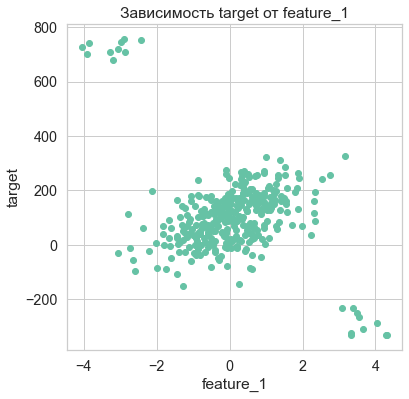

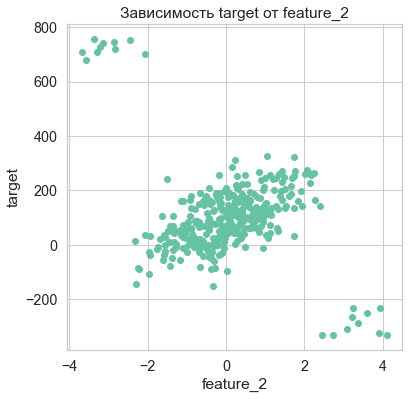

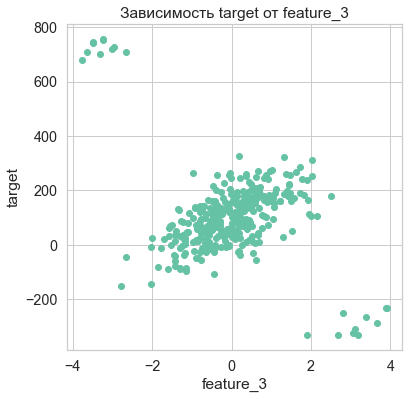

In [326]:
real_features=['feature_1','feature_2','feature_3']
for i,real_feature_now_i in enumerate(real_features):
    plt.figure(figsize=(6,6))
    plt.scatter(train[real_feature_now_i],train['target'])
    plt.xlabel(real_feature_now_i)
    plt.ylabel('target')
    plt.title('Зависимость target от {}'.format(real_feature_now_i))

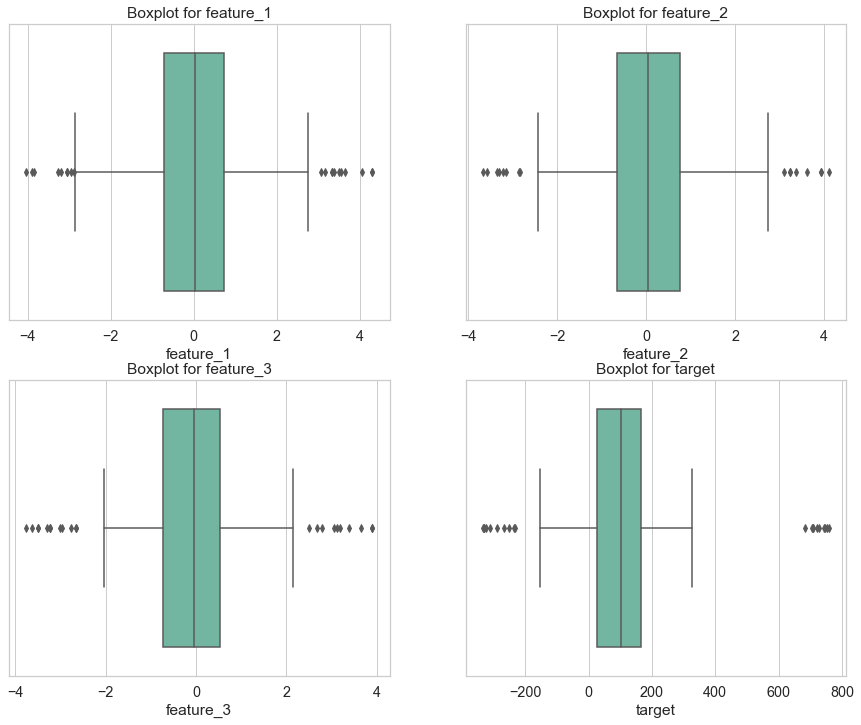

In [327]:
#смотрим на вещественные признаки, точнее на их выбросы
fig,axs = plt.subplots(2, 2,figsize=(15,12))
for i,real_feature_now_i in enumerate([*real_features,'target']):
    boxplot=sns.boxplot(x=train[real_feature_now_i], ax=axs[i//2,i-2*(i//2)])
    boxplot.set_title('Boxplot for {}'.format(real_feature_now_i))

Как хорошо видно, что у нас есть очень большие выбросы, причем это не разовые случаи. Это хорошо видно, как на графиках зависимости целевой переменной от каждого признака, так и по boxplot для каждого признака. В таком случае нам надо убрать выбросы, но в этом задании нас просят реализовать метод регрессии, который более устойчив к выбросам, то есть мы хотим сравнить Хьюбера и обычную линейную регрессию, когда есть выбросы. Так что давайте пока что не будем убирать выбросы

**2.** Обучите простую линейную регрессию и посчитайте качество на тестовой выборке по метрикам MSE, MAE и MAPE. Что можно сказать о качестве нашей модели?

In [328]:
fit_intercept=True
model=LinearRegression(fit_intercept=fit_intercept)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


MSE=metrics.mean_squared_error(y_test, y_pred)
print('MSE с оптимальным параметров для линейной регрессии равен {}'.format('%.3f' %MSE))

MAE=metrics.mean_absolute_error(y_test, y_pred)
print('MAE с оптимальным параметров для линейной регрессии равен {}'.format('%.3f' %MAE))

MAPE=metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE с оптимальным параметров для линейной регрессии равен {}'.format('%.3f' %MAPE))

MSE с оптимальным параметров для линейной регрессии равен 17025.807
MAE с оптимальным параметров для линейной регрессии равен 105.615
MAPE с оптимальным параметров для линейной регрессии равен 6.078


Как видно, у нас получились очень большие значения у метрик, хотя данных у нас не оч много. Такие плохие результаты связаны с тем, что мы не убрали выбросы, и наша модель обучалась на них тоже, что конечно испортило ее предсказания на не выбросах

**3.** Теперь обучите линейную регресcию Хьюбера и посчитайте качество на тестовой части по метрикам MSE, MAE и MAPE. Что изменилось? 

In [329]:
model=HuberRegression(fit_intercept=fit_intercept)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


MSE=metrics.mean_squared_error(y_test, y_pred)
print('MSE с оптимальным параметров для Хьюбера равен {}'.format('%.3f' %MSE))

MAE=metrics.mean_absolute_error(y_test, y_pred)
print('MAE с оптимальным параметров для Хьюбера равен {}'.format('%.3f' %MAE))

MAPE=metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE с оптимальным параметров для Хьюбера равен {}'.format('%.3f' %MAPE))

MSE с оптимальным параметров для Хьюбера равен 32.403
MAE с оптимальным параметров для Хьюбера равен 4.628
MAPE с оптимальным параметров для Хьюбера равен 0.232


Результаты изменились очень сильно, они стали лучше на 1-2 порядка, что является ужасно-большой разницей. Таким образом, регрессия Хьюбера уже показала свое превосходство, когда у нас много выбросов. Но давайте изучать дальше.

**4.** Используя кросс-валидацию, подберите оптимальное значение гиперпараметра $c$ нашей модели. Какую метрику стоит использовать? Почему?

In [45]:
from sklearn.model_selection import ShuffleSplit
metrics_list=['neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']
grid={'c' :np.logspace(-10,1,10**3)}
res=[]
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for metric in metrics_list:
    gs = GridSearchCV(
                # модель для обучения, в нашем случае Хюбер
                estimator=HuberRegression(fit_intercept=fit_intercept),
                # сетка значений гиперпараметров
                param_grid=grid,
                # метрика качества, берем MSE
                scoring=metric,
                # GridSearch отлично параллелится, указываем количество параллельных джоб
                # -1 означает использование всех ядер
                n_jobs=-1,
                # стратегия кросс-валидации
                cv=ss,
                # сообщения с логами обучения: больше значение - больше сообщений
                verbose=0,
                # значение, присваиваемое scorer в случае ошибки при обучении
                error_score='raise'
        )
    gs.fit(X_train, y_train)
    res.append(gs)
    print('При {} самый лучший параметр получается'.format(metric), gs.best_params_['c'])

При neg_mean_squared_error самый лучший параметр получается 0.3023294684405776
При neg_mean_absolute_error самый лучший параметр получается 1.8292045048462902
При neg_mean_absolute_percentage_error самый лучший параметр получается 1.8292045048462902


Я решил запустить все 3 вида метрики и посмотреь, что будет. Но если рассуждать теоретически, то вариант с MSE отпадает, так как MSE воспр. к выбросам, а их у нас много, как мы знаем. Поэтому я предложил бы использовать MAE или MAPE. MAPE мне кажется более наглядным, но при этом это обертка над MAE. 

In [46]:
#давайте вывыдем метрики для каждого лучшего гиперпараметра
for i,metric in enumerate(metrics_list):
    model=HuberRegression(fit_intercept=fit_intercept, c=res[i].best_params_['c'])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    MSE=metrics.mean_squared_error(y_test, y_pred)
    print('MSE с оптимальным параметров для {} равен {}'.format(metric,'%.3f' %MSE))

    MAE=metrics.mean_absolute_error(y_test, y_pred)
    print('MAE с оптимальным параметров для {} равен {}'.format(metric,'%.3f' %MAE))

    MAPE=metrics.mean_absolute_percentage_error(y_test, y_pred)
    print('MAPE с оптимальным параметров для  {} равен {}'.format(metric,'%.3f' %MAPE), end='\n')

MSE с оптимальным параметров для neg_mean_squared_error равен 7250.926
MAE с оптимальным параметров для neg_mean_squared_error равен 63.362
MAPE с оптимальным параметров для  neg_mean_squared_error равен 1.807
MSE с оптимальным параметров для neg_mean_absolute_error равен 22.725
MAE с оптимальным параметров для neg_mean_absolute_error равен 3.939
MAPE с оптимальным параметров для  neg_mean_absolute_error равен 0.187
MSE с оптимальным параметров для neg_mean_absolute_percentage_error равен 22.725
MAE с оптимальным параметров для neg_mean_absolute_percentage_error равен 3.939
MAPE с оптимальным параметров для  neg_mean_absolute_percentage_error равен 0.187


Как видно, ту модель, в которой гиперпараметр мы просили уменьшить MSE по train, MSE зашкаливает по сравнению с другими, так как у нас оч большие выбросы и на MSE бесполезно смотреть. Так что как я и предполагал будем смотреть на MAE/MAPE.

**5.** Для обучающей выборки постройте два графика (по графику на каждую модель), на которых изобразите зависимость истинного и предсказанного значения таргета от каждого признака. Что можно заметить на этих графиках?

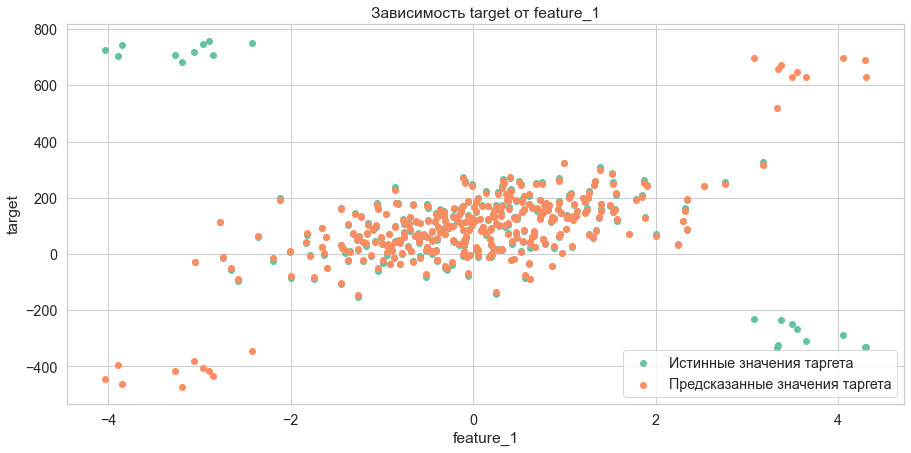

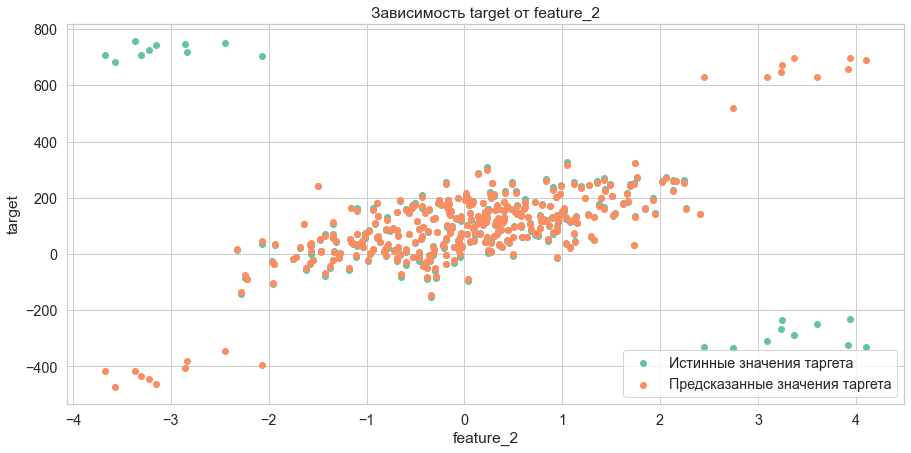

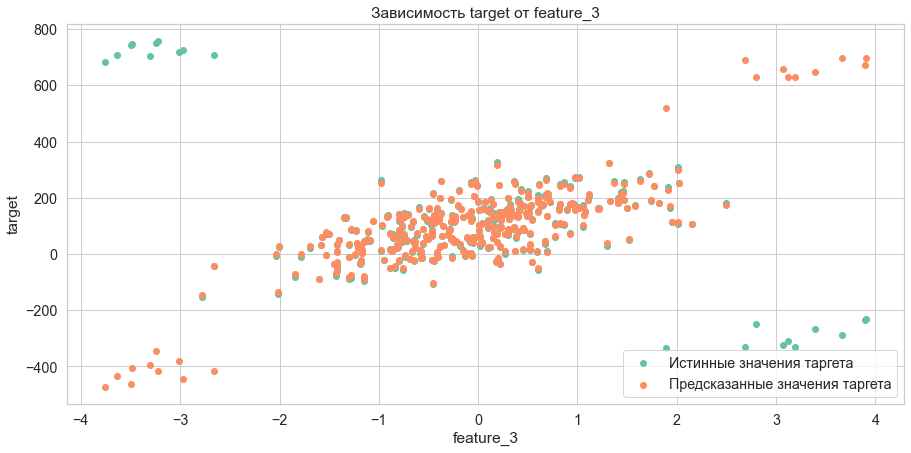

In [43]:
model=HuberRegression(fit_intercept=fit_intercept, c=res[i].best_params_['c'])
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

for i,real_feature_now_i in enumerate(real_features):
    plt.figure(figsize=(15,7))
    plt.scatter(train[real_feature_now_i],train['target'], label='Истинные значения таргета')
    plt.scatter(train[real_feature_now_i],y_pred, label='Предсказанные значения таргета')
    plt.xlabel(real_feature_now_i)
    plt.ylabel('target')
    plt.legend()
    plt.title('Зависимость target от {}'.format(real_feature_now_i))

**Вывод:** Как хорошо видно, Хьбер оч устойчив к выбросам, то есть он работает как MSE когда у нас большая разница и MSE, когда маленькая разница. Таким образом, если есть выбросы, то лучше использовать Хьюбера.